**Name: Rana Mohamed**

**ID : 5**

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
from pathlib import Path
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Loading DataSet

In [2]:
# loading the dataset from the drive
#defining the path of the flowers dataset
data = "/kaggle/input/flowers/flowers"

# using os.listdir() to get a list of all the subdirectories that exist in the flowers directory
directories = os.listdir(data)
print(f"The 'flowers' folder contains {len(directories)} subdirectories.")
print("Subdirectories:", directories)


The 'flowers' folder contains 5 subdirectories.
Subdirectories: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [3]:
X=[] # for image
Z=[] # for labels
flower_categories = []

# Iterate over each subdirectory (flower category)
for dir in directories:
    # Create the full path to the current subdirectory (flower category)
    dir_path = os.path.join(data, dir)
    #storing flowers categories' paths in an array
    flower_categories.append(dir_path)
    # Print how many images are in the current flower category folder
    print(f"{dir} folder has {len(os.listdir(dir_path))} images")



dandelion folder has 1052 images
daisy folder has 764 images
sunflower folder has 733 images
tulip folder has 984 images
rose folder has 784 images


# Appending Images (after resizing) and Labels into Arrays

In [4]:
def make_train_data(flower_type,DIR):
    """
    function to process images from a specific directory and then append them to images list 'x' and their corresponding labels to labels list 'z'.
    Parameters:
    flower_type: label of the flowers.
    DIR: directory path containing the images of that specific label.
    """
    # iterating over all images in the directory
    for img in os.listdir(DIR):
        label= flower_type
        # path of the image file
        path = os.path.join(DIR,img)
        # reading the image from the path, cv2.IMREAD_COLOR -> color mode
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        # resizing the images to ensure that all the images are of the same size
        img = cv2.resize(img, (200,200))
        # appending the image into images' array x and putting its label in Z
        X.append(np.array(img))
        Z.append(str(label)) # Indent the code within the function

In [5]:
make_train_data('Daisy',flower_categories[0])
make_train_data('Sunflower',flower_categories[1])
make_train_data('Tulip',flower_categories[2])
make_train_data('Dandelion',flower_categories[3])
make_train_data('Rose',flower_categories[4])

**Visualizing sample of the data**

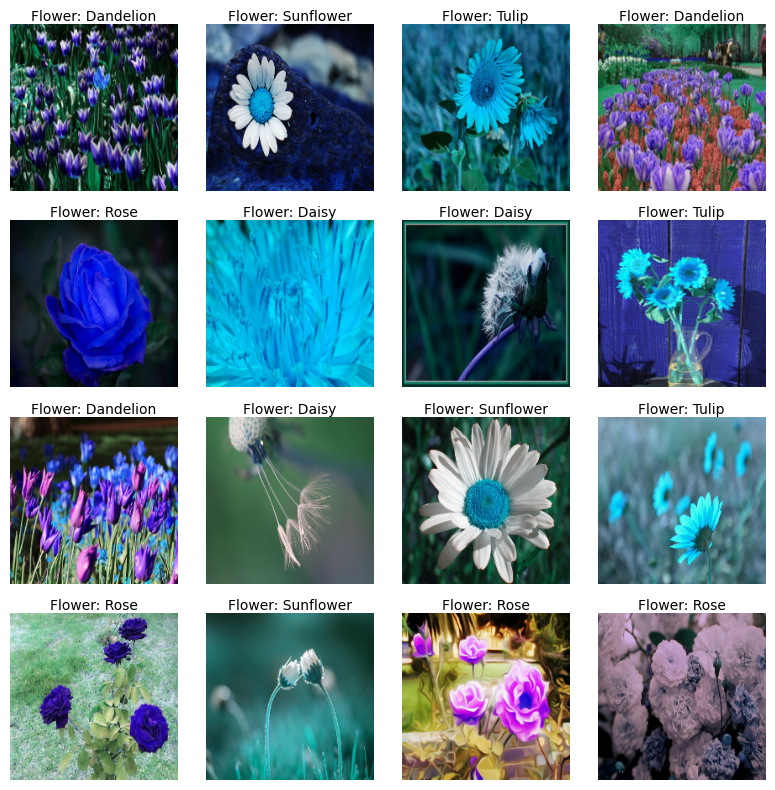

In [6]:
fig,ax=plt.subplots(4,4)
fig.set_size_inches(8,8)

for i in range(4):
    for j in range(4):
        l = rn.randint(0, len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(f'Flower: {Z[l]}', fontsize=10, pad=2)
        # removing x , y ticks and the spines of the subplots for a better visibility
        ax[i,j].axis('off')


plt.tight_layout()
plt.show()

# Data preprocessing -> Encoding , Normalization

In [7]:
Y = np.array(Z)
X = np.array(X)

In [8]:
le=LabelEncoder()
# Reshape Z to ensure it is a 1D array, and fit_transform encodes categorical labels into numeric form
Y=le.fit_transform(Y.reshape(-1))
# Convert the numeric labels to one-hot encoded format
Y=to_categorical(Y,5)

In [9]:
# Normalize the data
# X = X.astype(np.float16) / 255.0
X = X / 255.0
print("x_train shape: ",X.shape)

x_train shape:  (4317, 200, 200, 3)


In [10]:
# clean garbage collection
import gc
gc.collect()

122

# Train-Test Split

In [11]:

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)

x_train shape (3237, 200, 200, 3)
x_test shape (1080, 200, 200, 3)
y_train shape (3237, 5)
y_test shape (1080, 5)


# Data Augmentation

As the dataset is only 4317 and real-life examples sizes are in tera-bytes so to avoid overfitting I performed Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow(X_train, Y_train, batch_size=128)
val_gen = datagen.flow(X_test, Y_test, batch_size=128)

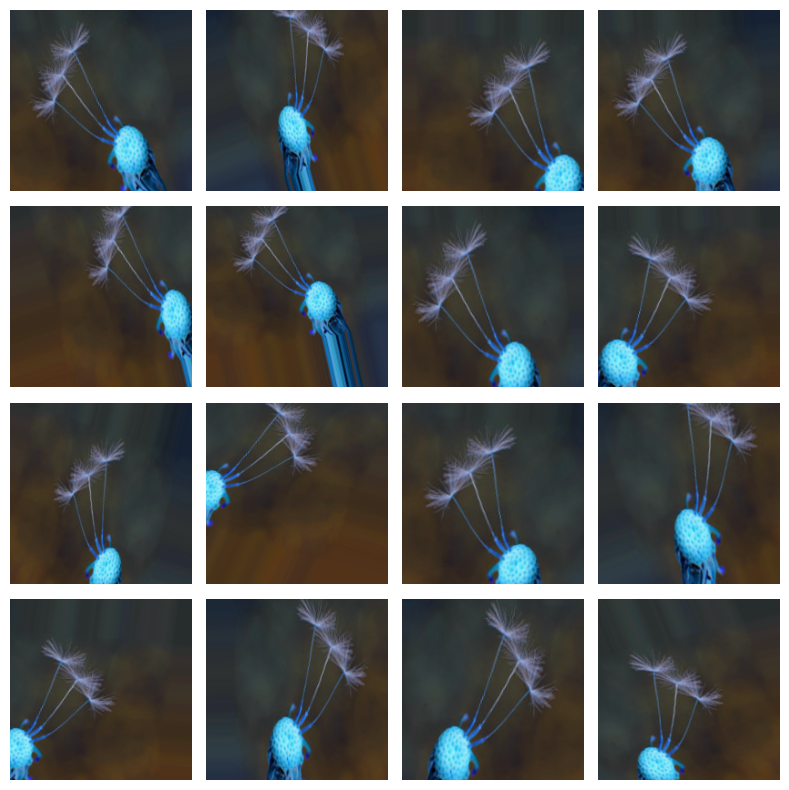

In [13]:
# visualization of the data augmentation on an image
fig,ax=plt.subplots(4,4)
fig.set_size_inches(8,8)

for i in range(4):
    for j in range(4):
        augmented_images = datagen.flow(np.expand_dims(X[0], axis=0), batch_size=1)
        augmented_image = next(augmented_images)[0]  
        ax[i,j].imshow(augmented_image)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

# Scratch CNN Model

**Creating the model**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

model = Sequential([
    # Convolutional layer with 16 filters, 5x5 kernel, same padding, ReLU activation
    Conv2D(filters=16, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(200, 200, 3)),
    
    # MaxPooling layer to reduce spatial dimensions by 2x2
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional layer with 32 filters, 3x3 kernel, same padding, ReLU activation
    Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    
    # MaxPooling layer with 2x2 pool size and strides of 2x2
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Convolutional layer with 64 filters, 3x3 kernel, same padding, ReLU activation
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    
    # MaxPooling layer with 2x2 pool size and strides of 2x2
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Convolutional layer with 128 filters, 3x3 kernel, same padding, ReLU activation
    Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'),
    
    # MaxPooling layer with 2x2 pool size and strides of 2x2
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Convolutional layer with 256 filters, 3x3 kernel, same padding, ReLU activation
    Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'),
    
    # MaxPooling layer with 2x2 pool size and strides of 2x2
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Dropout layer to prevent overfitting, dropping 20% of units
    Dropout(0.2),
    
    # Flatten layer to convert 3D feature maps into 1D vector
    Flatten(),
    
    # Dense layer with 512 neurons and ReLU activation
    Dense(512, activation='relu'),
    
    # Additional Dense layer with 256 neurons and ReLU activation
    Dense(256, activation='relu'),
    
    # Additional Dense layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),
    
    # Output Dense layer with 5 neurons for 5 classes, softmax activation for classification
    Dense(5, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compiling the model**

In [15]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,277,349 (20.13 MB)

 Trainable params: 5,277,349 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Fit the model
history = model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725685830.986596     109 service.cc:145] XLA service 0x7b25840020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725685830.986653     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725685830.986657     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/26 ━━━━━━━━━━━━━━━━━━━━ 9:52 24s/step - accuracy: 0.2969 - loss: 1.6071

I0000 00:00:1725685843.410278     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2606 - loss: 1.6061 - val_accuracy: 0.2667 - val_loss: 1.4818
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3539 - loss: 1.3952 - val_accuracy: 0.4593 - val_loss: 1.1912
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4729 - loss: 1.1977 - val_accuracy: 0.5491 - val_loss: 1.1425
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5591 - loss: 1.0761 - val_accuracy: 0.5917 - val_loss: 0.9892
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6057 - loss: 0.9963 - val_accuracy: 0.6583 - val_loss: 0.8968
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6475 - loss: 0.9076 - val_accuracy: 0.6306 - val_loss: 0.9197
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6270 - loss: 0.9203 - val_accuracy: 0.6565 - val_loss: 0.8774
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6422 - loss: 0.9019 - val_accuracy: 0.6750 - val_loss: 0.8785
Epo

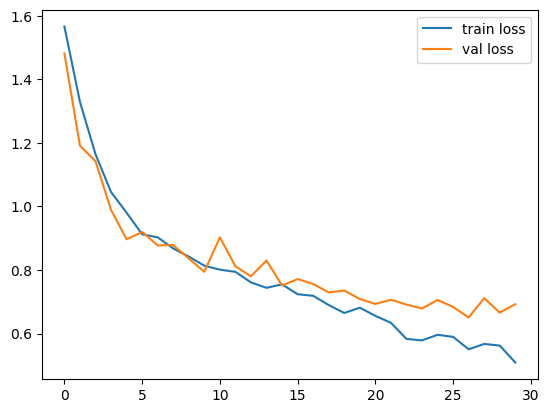

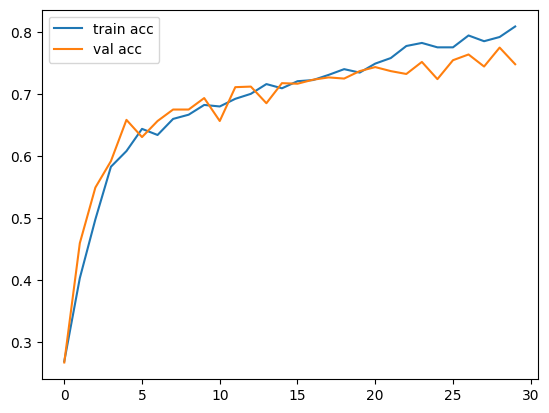

In [17]:
# Plot the loss curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


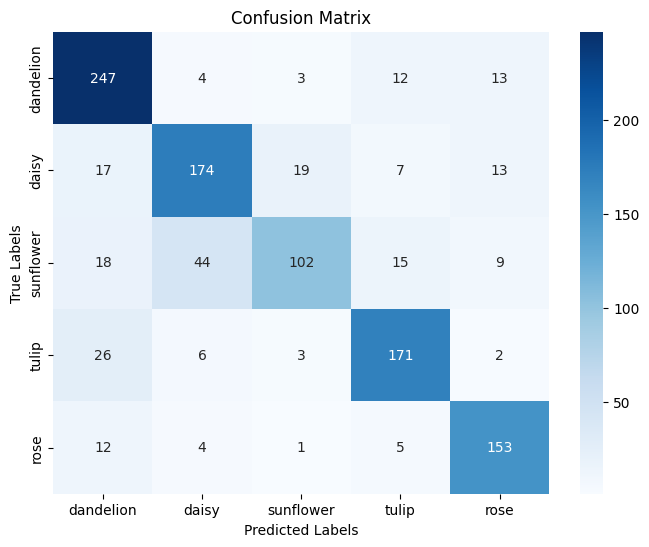

              precision    recall  f1-score   support

   dandelion       0.77      0.89      0.82       279
       daisy       0.75      0.76      0.75       230
   sunflower       0.80      0.54      0.65       188
       tulip       0.81      0.82      0.82       208
        rose       0.81      0.87      0.84       175

    accuracy                           0.78      1080
   macro avg       0.79      0.78      0.78      1080
weighted avg       0.79      0.78      0.78      1080



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
# Predict the classes for the test set
Y_pred = model.predict(X_test)
# Convert the predicted probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=directories, yticklabels=directories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred, target_names=directories))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


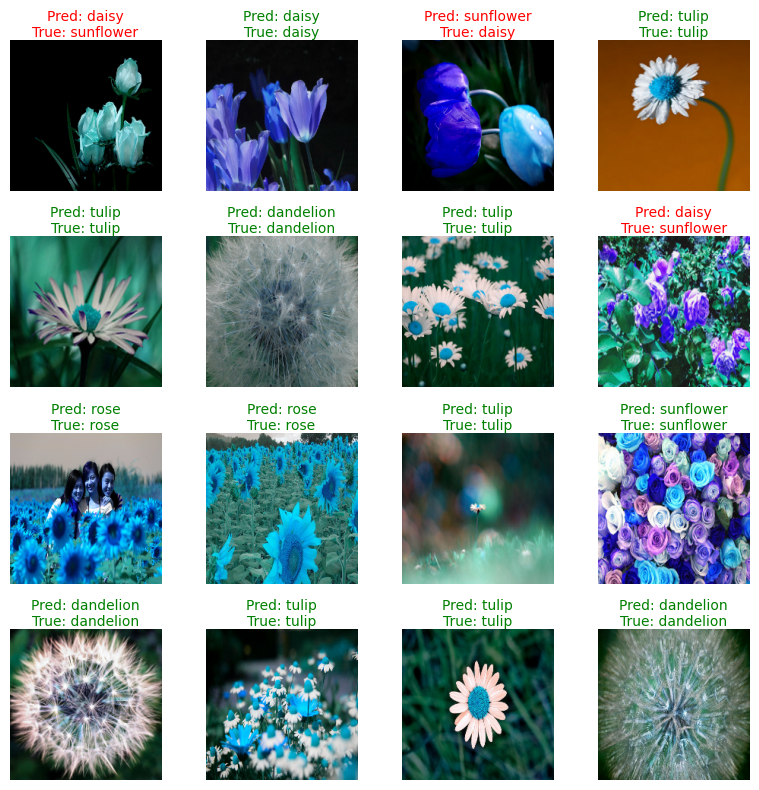

In [19]:
# Predict the classes for the test set
Y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)

y_test = np.argmax(Y_test, axis=1)

# Visualize predictions on the validation set
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
fig.set_size_inches(8, 8)

for i in range(4):
  for j in range(4):
    l = rn.randint(0, len(X_test))
    ax[i, j].imshow(X_test[l])
    
    # Get the predicted label
    predicted_label = directories[y_pred[l]]
    
    # Get the true label
    true_label = directories[y_test[l]]
    
    if y_pred[l] == y_test[l]:
      color = 'green'
    else:
      color = 'red'
    
    # Set the title with the predicted and true labels and color
    ax[i, j].set_title(f'Pred: {predicted_label}\nTrue: {true_label}', fontsize=10, pad=2, color=color)
    
    # Remove x and y ticks and the spines of the subplots for better visibility
    ax[i, j].axis('off')

plt.tight_layout()
plt.show()


# Building Resnet Model

![Resnet Architecture](https://www.researchgate.net/profile/Master-Prince/publication/350421671/figure/fig1/AS:1005790324346881@1616810508674/An-illustration-of-ResNet-50-layers-architecture.png)

**Resnet Model Architecture**

**1) Initial Convolution Layer:**
    1 Convolutional Layer (64 filters, 7x7 kernel)
    1 Max-Pooling Layer (3x3 kernel, stride 2)

**2) Residual Blocks:**

    Conv Block 1:

        3 Residual Blocks
                Each Residual Block:
                1 Convolutional Layer (64 filters, 1x1 kernel)
                1 Convolutional Layer (64 filters, 3x3 kernel)
                1 Convolutional Layer (256 filters, 1x1 kernel)
                
    Conv Block 2:

        4 Residual Blocks
                Each Residual Block:
                1 Convolutional Layer (128 filters, 1x1 kernel) 
                1 Convolutional Layer (128 filters, 3x3 kernel)
                1 Convolutional Layer (512 filters, 1x1 kernel) 

   Conv Block 3:

        6 Residual Blocks
            Each Residual Block:
            1 Convolutional Layer (256 filters, 1x1 kernel) 
            1 Convolutional Layer (256 filters, 3x3 kernel)
            1 Convolutional Layer (1024 filters, 1x1 kernel)

    Conv Block 4:

        3 Residual Blocks
            Each Residual Block:
            1 Convolutional Layer (512 filters, 1x1 kernel) 
            1 Convolutional Layer (512 filters, 3x3 kernel)
            1 Convolutional Layer (2048 filters, 1x1 kernel) 

**3) Average Pooling:**

    1 Average Pooling Layer 
    
**4) Fully Connected Layers:**

    1 Dense Layer 

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential

def create_resnet_model(input_shape=(200, 200, 3), num_classes=5):
    model = Sequential()

    # Initial Convolution and MaxPooling
    model.add(Conv2D(64, (7, 7), padding='same', strides=(2, 2), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # Residual Blocks 
    for filters in [64, 128, 256, 512]:
        model.add(Conv2D(filters, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(filters, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    
    # Global Average Pooling and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (200, 200, 3)
num_classes = 5  
model = create_resnet_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 256)    │       590,08

 Total params: 55,098,245 (210.18 MB)

 Trainable params: 55,094,277 (210.17 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [21]:
# Fit the model
history = model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2192 - loss: 17.8477 - val_accuracy: 0.2481 - val_loss: 1.7751
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2864 - loss: 1.6077 - val_accuracy: 0.1593 - val_loss: 1.6378
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3003 - loss: 1.4793 - val_accuracy: 0.2130 - val_loss: 1.6573
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3240 - loss: 1.4520 - val_accuracy: 0.1741 - val_loss: 1.6835
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3427 - loss: 1.4163 - val_accuracy: 0.2583 - val_loss: 1.8046
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3305 - loss: 1.4304 - val_accuracy: 0.2130 - val_loss: 1.7061
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3405 - loss: 1.4017 - val_accuracy: 0.2130 - val_loss: 1.8802
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3761 - loss: 1.3437 - val_accuracy: 0.2130 - val_loss

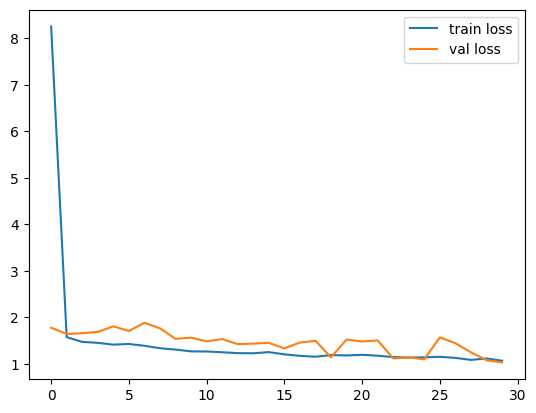

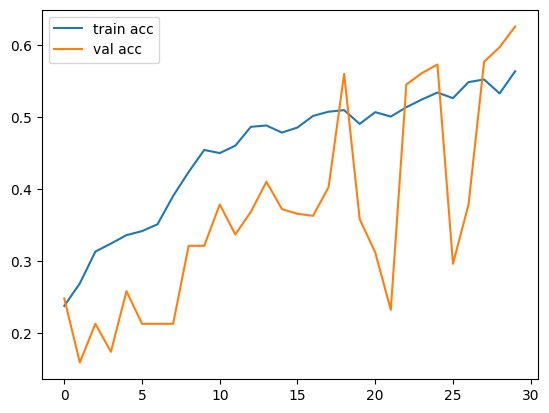

In [22]:
# Plot the loss curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


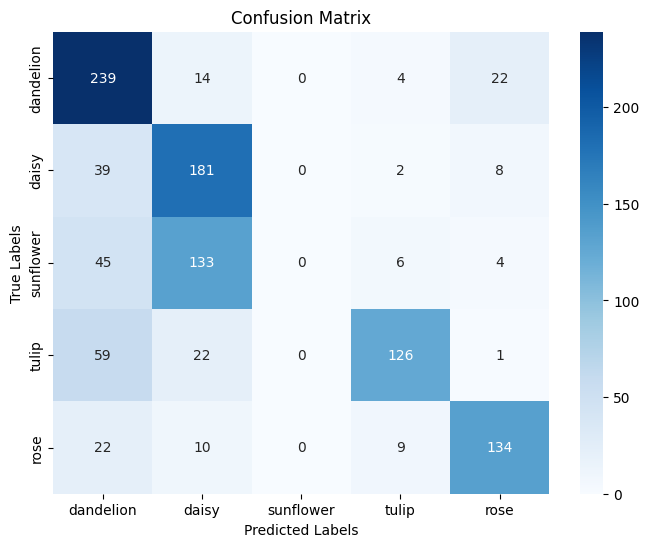

              precision    recall  f1-score   support

   dandelion       0.59      0.86      0.70       279
       daisy       0.50      0.79      0.61       230
   sunflower       0.00      0.00      0.00       188
       tulip       0.86      0.61      0.71       208
        rose       0.79      0.77      0.78       175

    accuracy                           0.63      1080
   macro avg       0.55      0.60      0.56      1080
weighted avg       0.55      0.63      0.57      1080



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
# Predict the classes for the test set
Y_pred = model.predict(X_test)
# Convert the predicted probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=directories, yticklabels=directories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred, target_names=directories))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


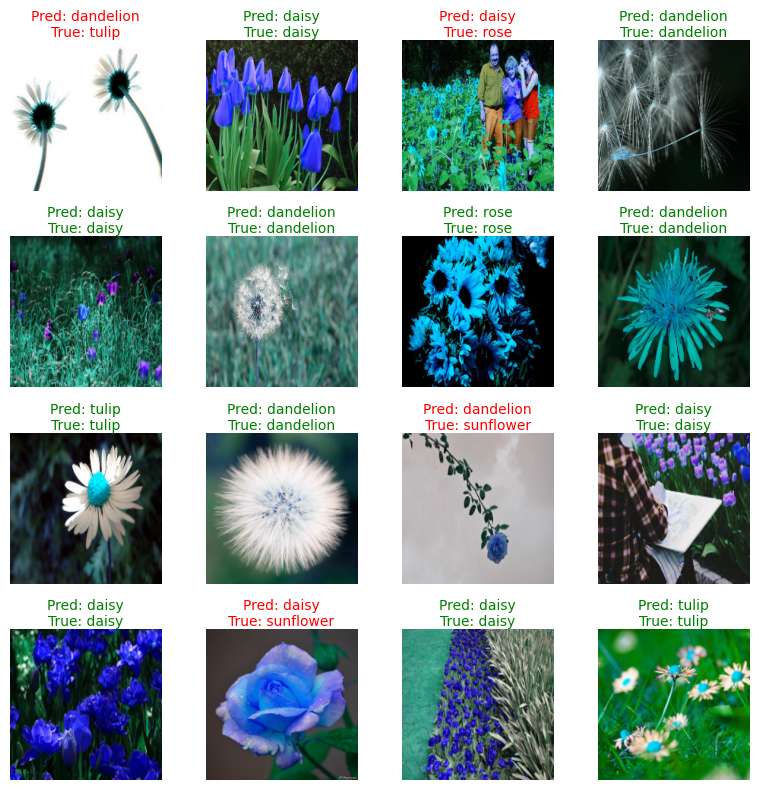

In [24]:
# Predict the classes for the test set
Y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)

y_test = np.argmax(Y_test, axis=1)

# Visualize predictions on the validation set
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
fig.set_size_inches(8, 8)

for i in range(4):
  for j in range(4):
    l = rn.randint(0, len(X_test))
    ax[i, j].imshow(X_test[l])
    
    # Get the predicted label
    predicted_label = directories[y_pred[l]]
    
    # Get the true label
    true_label = directories[y_test[l]]
    
    if y_pred[l] == y_test[l]:
      color = 'green'
    else:
      color = 'red'
    
    # Set the title with the predicted and true labels and color
    ax[i, j].set_title(f'Pred: {predicted_label}\nTrue: {true_label}', fontsize=10, pad=2, color=color)
    
    # Remove x and y ticks and the spines of the subplots for better visibility
    ax[i, j].axis('off')

plt.tight_layout()
plt.show()
